In [2]:
import os
from PIL import Image
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [5]:
data_dir = r'C:\Users\User\ODL Ass\bird25'
img_height, img_width = 224, 224
BATCH_SIZE = 32

In [19]:
# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  
    color_mode='rgb',
    subset='validation'
)



Found 30000 images belonging to 25 classes.
Found 7500 images belonging to 25 classes.


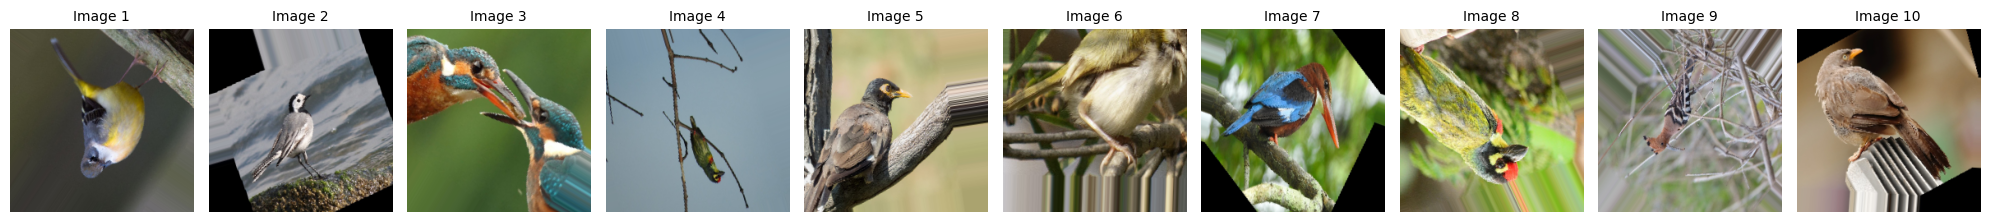

In [22]:
import matplotlib.pyplot as plt
images, labels = next(train_generator)
num_images = 10  
plt.figure(figsize=(20, 10))

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[i])
    plt.title(f"Image {i+1}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()



In [14]:
# TensorBoard Callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
#Set InceptionResNetV2 as base model
base_model = tf.keras.applications.InceptionResNetV2(input_shape=(img_height, img_width, 3),
                                                     include_top=False,
                                                     weights='imagenet')

# Freeze the base model
base_model.trainable = False
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)

# Global average pooling
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Dense layers
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(25, activation='softmax')(x)

# Define the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer_adam, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# Train Model Function
def train_model(model, train_generator, valid_generator, log_dir, initial_epochs, fine_tune_epochs, fine_tune_at):
    # TensorBoard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    # EarlyStopping and ReduceLROnPlateau callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
    model_check = tf.keras.callbacks.ModelCheckpoint('TLInceptionResNetV2_model.keras', monitor='val_loss', save_best_only=True)

    callbacks = [early_stop, reduce_lr, model_check, tensorboard_callback]

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=initial_epochs,
        callbacks=callbacks,
        verbose=1
    )

    # Unfreeze layers of the base model for fine-tuning
    base_model.trainable = True

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Recompile the model 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Fine-tune the model
    history_fine = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=fine_tune_epochs,
        callbacks=callbacks,
        verbose=1
    )

    return history, history_fine

In [4]:
# Parameters and Train the Model
initial_epochs = 20
fine_tune_epochs = 5
fine_tune_at = 100


history, history_fine = train_model(model, train_generator, validation_generator, log_dir, initial_epochs, fine_tune_epochs, fine_tune_at)



Epoch 1/20


d:\ananconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 1624s 2s/step - accuracy: 0.2226 - loss: 3.1065 - val_accuracy: 0.7089 - val_loss: 1.0139 - learning_rate: 1.0000e-04
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1283s 1s/step - accuracy: 0.4982 - loss: 1.7100 - val_accuracy: 0.7759 - val_loss: 0.7794 - learning_rate: 1.0000e-04
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1374s 1s/step - accuracy: 0.5861 - loss: 1.4022 - val_accuracy: 0.8020 - val_loss: 0.6857 - learning_rate: 1.0000e-04
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1231s 1s/step - accuracy: 0.6279 - loss: 1.2544 - val_accuracy: 0.8220 - val_loss: 0.6075 - learning_rate: 1.0000e-04
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1227s 1s/step - accuracy: 0.6691 - loss: 1.1144 - val_accuracy: 0.8325 - val_loss: 0.5595 - learning_rate: 1.0000e-04
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1233s 1s/step - accuracy: 0.6835 - loss: 1.0618 - val_accuracy: 0.8401 - val_loss: 0.5416 - learning_rate: 1.0000e-04
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1232s 1s/step - accurac

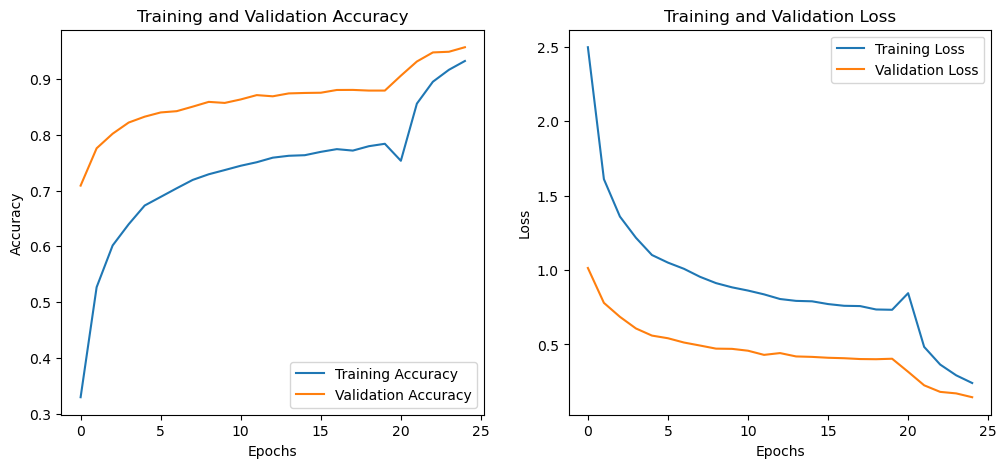

In [5]:


def plot_training_history(history, history_fine):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc_fine = history_fine.history['accuracy']
    val_acc_fine = history_fine.history['val_accuracy']
    loss_fine = history_fine.history['loss']
    val_loss_fine = history_fine.history['val_loss']

    total_acc = acc + acc_fine
    total_val_acc = val_acc + val_acc_fine
    total_loss = loss + loss_fine
    total_val_loss = val_loss + val_loss_fine

    total_epochs = range(len(total_acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(total_epochs, total_acc, label='Training Accuracy')
    plt.plot(total_epochs, total_val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(total_epochs, total_loss, label='Training Loss')
    plt.plot(total_epochs, total_val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history, history_fine)


In [8]:

model = tf.keras.models.load_model('TLInceptionResNetV2_model.keras')
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.9633 - loss: 0.1296
Validation Loss: 0.14529770612716675
Validation Accuracy: 0.9570666551589966


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np

model = tf.keras.models.load_model('TLInceptionResNetV2_model.keras')
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

f1 = f1_score(true_classes, predicted_classes, average='weighted')
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')

print(f"Validation F1 Score: {f1}")
print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

235/235 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step
Validation F1 Score: 0.9571485959906318
Validation Precision: 0.957540139204875
Validation Recall: 0.9570666666666666
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.96      0.96      0.96       300
      Brown-Headed-Barbet       0.95      0.95      0.95       300
             Cattle-Egret       0.98      0.99      0.99       300
        Common-Kingfisher       0.98      0.96      0.97       300
              Common-Myna       0.97      0.96      0.97       300
         Common-Rosefinch       0.88      0.90      0.89       300
        Common-Tailorbird       0.91      0.94      0.92       300
       Coppersmith-Barbet       0.96      0.93      0.95       300
           Forest-Wagtail       0.98      0.92      0.95       300
             Gray-Wagtail       0.96      0.94      0.95       300
                   Hoopoe       0.99      0.98      0.99       300
               House-Crow       0.9